In [18]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from sympy.solvers import solve
import seaborn as sns
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def Plot(v, f1, str1, f2, str2, f3, str3, ylabel):
    #print(str1, str2, str3, ylabel)
    plt.plot(v, f1, label=str1)
    plt.plot(v, f2, label=str2)
    plt.plot(v, f3, label=str3)
    
    plt.legend()
    plt.grid()
    plt.xlabel("Voltage v (mV)")
    plt.ylabel(ylabel)
    plt.show()

## Question 1

### Defining the Alpha, Beta equations

In [3]:
alpha_m = lambda V : (2.5 - 0.1 * (V)) / (np.exp(2.5 - 0.1 * (V)) - 1)
alpha_n = lambda V : (0.1 - 0.01 * (V)) / (np.exp(1 - 0.1 * (V)) - 1)
alpha_h = lambda V : 0.07* np.exp((V)/-20.0)

beta_m = lambda V : 4* np.exp((V)/-18.0)
beta_n = lambda V : 0.125* np.exp((V)/-80.0)
beta_h = lambda V : 1/(np.exp(3-0.1*(V)) + 1)

### Defining the Steady state and time constant equations

In [4]:
steady_state_m = lambda V: alpha_m(V)/(alpha_m(V) + beta_m(V))
steady_state_n = lambda V: alpha_n(V)/(alpha_n(V) + beta_n(V))
steady_state_h = lambda V: alpha_h(V)/(alpha_h(V) + beta_h(V))

time_constant_m = lambda V, T: 1/((3.0**(0.1*(T-6.3)))*(alpha_m(V) + beta_m(V)))
time_constant_n = lambda V, T: 1/((3.0**(0.1*(T-6.3)))*(alpha_n(V) + beta_n(V)))
time_constant_h = lambda V, T: 1/((3.0**(0.1*(T-6.3)))*(alpha_h(V) + beta_h(V)))

## Question 2 (Hodgkin Huxley)

In [5]:
def PlotMembranePotential(T, V):
    plt.plot(T,V, label="Membrane Potential")
    plt.grid()
    plt.legend()
    plt.xlabel("Time t (ms)")
    plt.ylabel("V(t) (mV)")
    plt.show()

In [6]:
def PlotGatingVariables(T, M, N, H):
    plt.plot(T,M, label="m")
    plt.plot(T,N, label="n")
    plt.plot(T,H, label="h")
    plt.grid()
    plt.legend()
    plt.xlabel("Time t (ms)")
    plt.ylabel("P(t)")
    plt.show()

In [7]:
def PlotCurrents(T, i_Na, i_K):
    plt.plot(T,i_Na, label="$i_{Na}$")
    plt.plot(T,i_K, label="$i_{K}$")
    plt.grid()
    plt.legend()
    plt.xlabel("Time t (ms)")
    plt.ylabel("i(t) ($10^{-6}$A/$cm^2$)")
    plt.show()

In [8]:
def PlotPhasePlot(V, i_Na, i_K, i_L):
    plt.plot(V,i_Na, label="$i_{Na}$")
    plt.plot(V,i_K, label="$i_{K}$")
    plt.plot(V,i_L, label="$i_{L}$")
    plt.grid()
    plt.legend()
    plt.xlabel("Voltage V (mV)")
    plt.ylabel("i(t) ($10^{-6}$A/$cm^2$)")
    plt.show()

**Calculating the Coefficients A and B for corresponding Gating Variable DE**

In [9]:
k = lambda T: 3.0**(0.1*(T-6.3))
A_m = lambda V,temp: -1 * (alpha_m(V) + beta_m(V)) * k(temp)
B_m = lambda V,temp: alpha_m(V)*k(temp)
A_n = lambda V,temp: -1 * (alpha_n(V) + beta_n(V)) * k(temp)
B_n = lambda V,temp: alpha_n(V)*k(temp)
A_h = lambda V,temp: -1 * (alpha_h(V) + beta_h(V)) * k(temp)
B_h = lambda V,temp: alpha_h(V)*k(temp)


**Implementation of HH Model**

In [83]:
def IHHExp(num_comp, i_stim, T, V_init, m_init, n_init, h_init, V_Na, V_K, V_L, g_Na, g_K, g_L, C_m, R_a, dt, temp, A_m, B_m, A_n, B_n, A_h, B_h):
        
    Identity_vec = np.ones(num_comp)
    
    M = np.zeros((num_comp,len(T)))
    N = np.zeros((num_comp,len(T)))
    H = np.zeros((num_comp,len(T)))
    
    i_Na = np.zeros((num_comp,len(T)))
    i_K = np.zeros((num_comp,len(T)))
    i_L = np.zeros((num_comp,len(T)))
    
    V = np.zeros((num_comp,len(T)))
    
    M[:,0] = m_init*Identity_vec
    N[:,0] = n_init*Identity_vec
    H[:,0] = h_init*Identity_vec
    
    V[:,0] = V_init*Identity_vec
    
    V_Nam = V_Na * Identity_vec
    V_Km = V_K * Identity_vec
    V_Lm = V_L * Identity_vec

    combination = np.zeros((num_comp,num_comp))
    combination[0][0] = -1
    combination[0][1] = 1
    for i in range(1,num_comp-1):
        combination[i][i] = -2
        combination[i][i-1] = 1
        combination[i][i+1] = 1
    combination[i+1][i+1] = -1
    combination[i+1][i] = 1

    A = np.identity(num_comp) - (dt/(C_m*R_a))*combination

    for i in range(1,len(T)):
        M[:, i] = M[:, i-1]*np.exp(A_m(V[:, i-1],temp)*dt) + (B_m(V[:, i-1], temp)/A_m(V[:, i-1],temp))*(np.exp(A_m(V[:, i-1], temp)*dt)-1)
        N[:, i] = N[:, i-1]*np.exp(A_n(V[:, i-1],temp)*dt) + (B_n(V[:, i-1], temp)/A_n(V[:, i-1],temp))*(np.exp(A_n(V[:, i-1], temp)*dt)-1)
        H[:, i] = H[:, i-1]*np.exp(A_h(V[:, i-1],temp)*dt) + (B_h(V[:, i-1], temp)/A_h(V[:, i-1],temp))*(np.exp(A_h(V[:, i-1], temp)*dt)-1)
        
        i_Na[:,i] = g_Na*(M[:,i-1]**3)*H[:,i-1]*(V[:,i-1]-V_Nam)
        i_K[:,i] = g_K*(N[:,i-1]**4)*(V[:,i-1]-V_Km)
        i_L[:,i] = g_L*(V[:,i-1]-V_Lm)

        B = V[:, i-1] + (dt/C_m)*(i_stim[:,i]-i_Na[:,i]-i_K[:,i]-i_L[:,i])
        V[:,i] = np.linalg.solve(A,B)
        
    return V

In [126]:
num_comp = 100
resistivity = 0.1
length = 1e-5
radius = 2e-4

R_a = lambda ra, rhoa, la: ((rhoa * la)/(np.pi*ra*ra))

R_axon = R_a(radius,resistivity,length)
r_axon = R_axon/length

**Defining the Input current**

In [116]:
dt = 0.025

T = np.arange(0,100,dt)

I_stim1 = np.zeros((num_comp,len(T)))
tem = int(5/dt)
t_Arr = range(tem+1)
I_stim1[0,t_Arr] = 10

I_stim2 = np.zeros((num_comp,len(T)))
I_stim2[19,t_Arr] = 10
I_stim2[79,t_Arr] = 10

**Defining the initial parameters**

In [133]:
V_init = 0
m_init = steady_state_m(V_init)
n_init = steady_state_n(V_init)
h_init = steady_state_h(V_init)


V_Na = 115
V_K = -12
V_L = 10.6
g_Na = 120
g_K = 36
g_L = 0.3
C_m = 1
V_rest = -70

**HH values for Temp = 6.3 and current I1**

In [131]:
V1 = IHHExp(num_comp, I_stim1, T, V_init, m_init, n_init, h_init, V_Na, V_K, V_L, g_Na, g_K, g_L, C_m, R_axon, dt, 6.3, A_m, B_m, A_n, B_n, A_h, B_h)

In [109]:

V2 = IHHExp(num_comp, I_stim2, T, V_init, m_init, n_init, h_init, V_Na, V_K, V_L, g_Na, g_K, g_L, C_m, R_axon, dt, 12, A_m, B_m, A_n, B_n, A_h, B_h)


In [97]:
def PlotCM(V):
    
    plt.figure(figsize=(10, 10), dpi=100)
    ax1 = plt.subplot(111)
    im1 = ax1.imshow(V, cmap='magma', aspect='auto', origin='lower', extent=[0, 100, 0, 100])
    plt.xlabel('t (ms)', fontsize=13)
    plt.ylabel('Compartment Nr.', fontsize=13)
    plt.xticks(np.arange(0, 101, 10))
    plt.yticks(np.arange(0, 101, 10))
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.1)
    cbar1 = plt.colorbar(im1, cax=cax1)
    cbar1.set_label('V (mV)', fontsize=13)
    plt.savefig('voltage.pdf')
    plt.show();

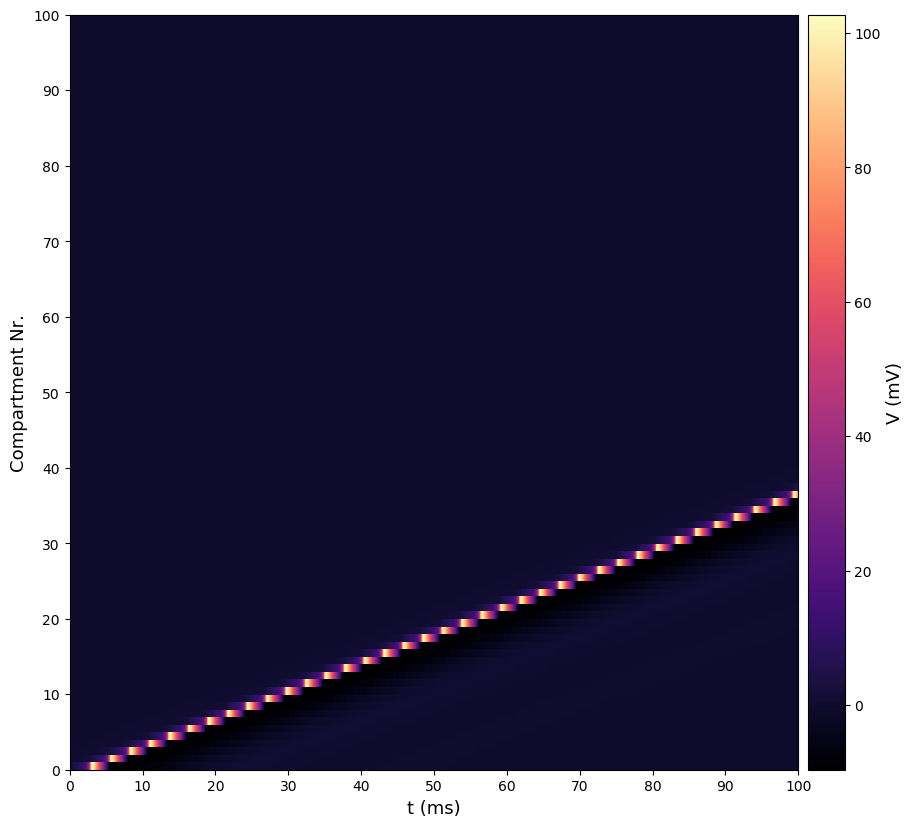

In [132]:
PlotCM(V1)